## 1. Prepare input data

Train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/text8.zip) data.

In [34]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Read the data into a string. Reference to 
[compat](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/util/compat.py) function. `Text8` contains about 17 million words.

In [35]:
# Extract the first file enclosed in a zip file as a list of words
def read_data(filename):  
    with zipfile.ZipFile(filename) as f:
        # Convert input into string. 
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data('text8.zip')
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with RARE token.

In [36]:
vocabulary_size = 10000
def build_dataset(words):
    count = [['RARE', -1]]
    # Extract 10000 most common words in this dataset
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    dictionary = {} # dictionary of (word, rank of that word in terms of frequency)
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = []  # data contains the rank of 
    for word in words: # 
        data.append(dictionary.get(word, 0)) # 0  is for dictionary['UNK']        
    
    # dictionary of (rank of a word in terms of frequency, word)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, reverse_dictionary

data, reverse_dictionary = build_dataset(words)
print('Sample reverse dictionary', reverse_dictionary.items()[:10])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Sample reverse dictionary [(0, 'RARE'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


## 2. Prepare Word2Vec skip-gram model

Function to generate a training batch for the skip-gram model.

In [37]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
    
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print('batch:', [reverse_dictionary[bi] for bi in batch])
print('labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']


### 2.1. Build the graph

In [38]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

# Create a Tensorflow graph
graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], 
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### 2.2 Train the Word2Vec model

In [39]:
num_steps = 10001 # 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
  
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
      
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        sim = similarity.eval()
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.770333
Average loss at step 2000: 3.873810
Average loss at step 4000: 3.559099
Average loss at step 6000: 3.550868
Average loss at step 8000: 3.475054
Average loss at step 10000: 3.411485
Nearest to three: four, five, eight, six, seven, two, nine, zero,
Nearest to its: the, his, their, perceived, this, assembled, unesco, responsible,
Nearest to can: would, might, cannot, may, will, edu, fruits, could,
Nearest to this: it, the, which, allegiance, its, that, bull, subdivisions,
Nearest to their: his, its, the, copy, discharge, this, renewed, control,
Nearest to up: besides, idaho, questions, levy, win, planning, deep, singing,
Nearest to as: evolutionary, became, by, burden, gathering, ipcc, rough, mercedes,
Nearest to most: acted, dick, era, philosophies, ratios, vatican, cube, shortened,
Nearest to such: bath, murray, effective, studying, sri, carolina, gaining, enduring,
Nearest to one: six, two, three, eight, four, five, void, seven,
Nearest to h

## 3. Visualize the word vectors

In [40]:
num_points = 50

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

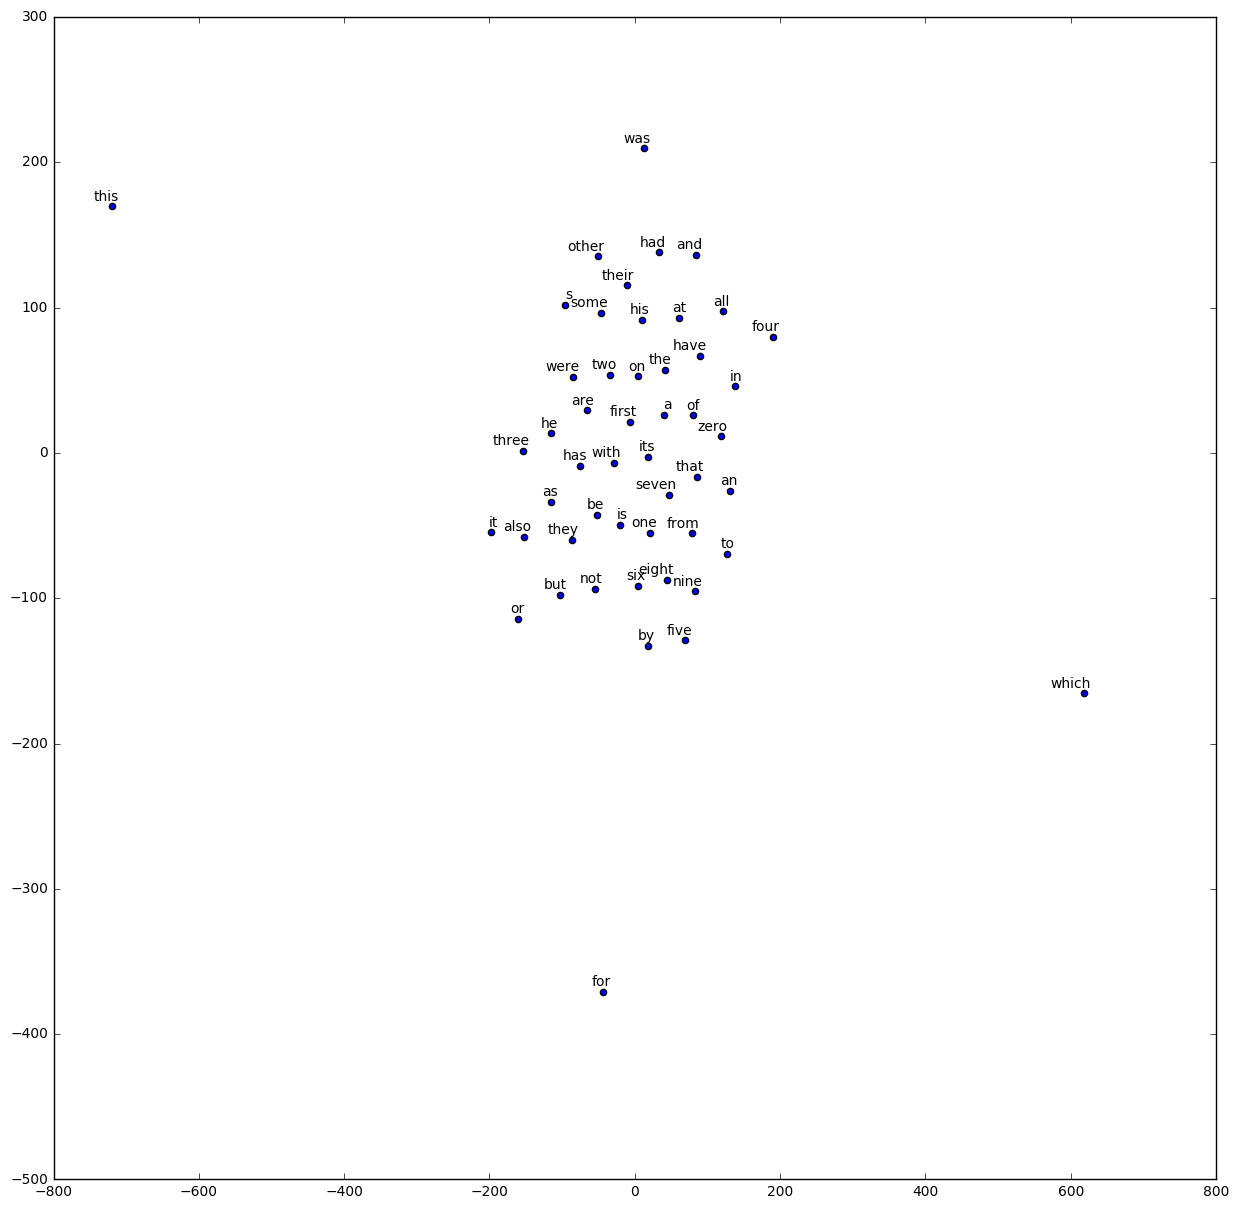

In [41]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## References
* https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity